In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from scipy.stats import logistic
from Main_functions import *
import random
from numpy import genfromtxt
import time 

### Setting the data distribuation 

Pairs $(x_i,y_i)\in \mathbb{R}^d\times \mathbb{R}^d$ for $i=1, \ldots, N$ are generated i.i.d. from density distribuation $f(\cdot)\times f(\cdot)$.  

Parameters:

$d:$ dimention of data points

$N:$ number of pairs

$f(\cdot):$ density distribuation


### Given the eigenvalues of ground truth $M_t$, we randomly generate it.

In [59]:
csv_path = 'CSVs/logistic_logistic_'
image_path = 'Images/logistic_logistic_'
title_suffix = '\n Logistic Noise Logistic model\n (d=100 & rank(M) = 30)'
noise_type = 'Logistic'
model_type = 'Logistic'

In [3]:
d = 100
rank = 30
seed = 2023

In [4]:
np.random.seed(seed)
non_zero_eigens_of_M_star = np.round(np.random.uniform(low=0.0, high=1.0, size= rank), 2)
non_zero_eigens_of_M_star

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.47, 0.02, 0.73, 0.52, 0.54, 0.46,
       0.5 , 0.39, 0.15, 0.36, 0.16, 0.34, 0.18, 0.39, 0.04, 0.56, 0.2 ,
       0.32, 0.38, 0.18, 0.1 , 0.45, 0.2 , 0.38, 0.93])

In [5]:
# eigenvalues of $M_t$
diag = np.zeros(d)
diag[:rank] = non_zero_eigens_of_M_star
diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.47, 0.02, 0.73, 0.52, 0.54, 0.46,
       0.5 , 0.39, 0.15, 0.36, 0.16, 0.34, 0.18, 0.39, 0.04, 0.56, 0.2 ,
       0.32, 0.38, 0.18, 0.1 , 0.45, 0.2 , 0.38, 0.93, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [6]:
data_model = DG(diag, seed = 22)

Ground truth M_t and B_t are generated (M_t = B_t @ B_t.T)
To access to M_t and B_t, use .M_t and .B_t


In [7]:
data_model.M_diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.47, 0.02, 0.73, 0.52, 0.54, 0.46,
       0.5 , 0.39, 0.15, 0.36, 0.16, 0.34, 0.18, 0.39, 0.04, 0.56, 0.2 ,
       0.32, 0.38, 0.18, 0.1 , 0.45, 0.2 , 0.38, 0.93, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [8]:
data_model.M_t.shape, data_model.B_t.shape

((100, 100), (100, 100))

### Given the eigenvalue of covariance matrix Cov, we randomly generate it.

In [9]:
np.random.seed(2024)
diag_cov = np.round(np.random.uniform(low=0.0, high=1.0, size= d), 2)
diag_cov

array([0.59, 0.7 , 0.19, 0.04, 0.21, 0.11, 0.73, 0.68, 0.47, 0.45, 0.02,
       0.75, 0.6 , 0.96, 0.66, 0.61, 0.45, 0.23, 0.67, 0.74, 0.26, 0.1 ,
       0.96, 0.25, 0.28, 0.77, 0.8 , 0.54, 0.38, 0.38, 0.29, 0.74, 0.24,
       0.44, 0.88, 0.29, 0.78, 0.76, 0.42, 0.23, 0.42, 0.06, 0.6 , 0.84,
       0.89, 0.2 , 0.5 , 0.9 , 0.26, 0.87, 0.02, 0.55, 0.53, 0.92, 0.25,
       0.06, 0.9 , 0.87, 0.16, 1.  , 0.35, 0.31, 0.85, 0.88, 0.68, 0.05,
       0.56, 0.69, 0.82, 0.31, 0.51, 0.85, 0.29, 0.68, 0.42, 0.68, 0.22,
       0.55, 0.85, 0.74, 0.5 , 0.38, 0.79, 0.17, 0.59, 0.43, 0.06, 0.29,
       0.73, 0.29, 0.39, 0.64, 0.83, 0.32, 0.16, 0.71, 0.87, 0.59, 0.69,
       0.17])

In [10]:
diag_cov.sum()

51.339999999999996

In [11]:
Sigma, U_sigma = random_covariance(diag_cov, seed = 21)

In [12]:
f = multivariate_normal(mean = np.zeros(d), cov = Sigma)

### What is the average of squared norm of points generating where $x\sim f(x)$ with $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$

If $x\sim f(x)$ where $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$, then 
\begin{align}
\mathbb{E}\left(x^\top Mx\right) & = \mathbb{E}\left({\rm tr}(x^\top Mx)\right)\\
 & = \mathbb{E}\left({\rm tr}(xx^\top M)\right)\\
 & = {\rm tr}\left(\mathbb{E}\left(xx^\top\right)M\right)\\
 & = {\rm tr}\left(\left[{\rm Cov}(x) - \mathbb{E}(x)\mathbb{E}(x)^\top\right]M\right)
\end{align}

If we set  $\mu = \mathbf{0}$, then 
$$\mathbb{E}\left(x^\top Mx\right) = {\rm tr}\left(\Sigma M\right).$$
Therefore, since $x$ and $y$ are independent, 
$$\mathbb{E}\left(\|x-y\|_M^2\right) = 2{\rm tr}\left(\Sigma M\right).$$

In [13]:
snm = 2 * np.trace(data_model.M_t @ Sigma)
print("squared norm mean = {}".format(snm))

squared norm mean = 11.29846430528854


### Check the average empirically

In [14]:
N = 5000
X_1, Y_1 = sample(f, N)
sn = (((X_1 - Y_1) @ data_model.B_t)**2).sum()/N
print("emperical squared norm mean = {}".format(sn))

emperical squared norm mean = 11.3058906083702


### Set $\tau$ to generate data points

In [15]:
tau = [11]
N = 150000
s = 1.5

In [16]:
var = logistic(loc = 0, scale = s).var()
var

7.4022033008170185

In [17]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                          noise_type = noise_type, noise_par = s)

In [18]:
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

the amount of noise: 0.20324666666666666


In [19]:
for i in range(len(tau)+1):
    print('number of pairs with {} as their labels is {}'.format(i,(D_no_noisy==i).sum()))

number of pairs with 0 as their labels is 77241
number of pairs with 1 as their labels is 72759


In [20]:
(D_no_noisy== 0).sum()/N

0.51494

### Change to PyTorch tensor!

In [21]:
X = torch.tensor(X, dtype = torch.float64)
Y = torch.tensor(Y, dtype = torch.float64)
D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)

In [22]:
X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                 Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = 100000)

In [23]:
X.dtype, D.dtype

(torch.float64, torch.int64)

## Sample complexity

In [24]:
k = d
n_labels = len(tau)+1

In [25]:
H = []
J = []
N = 20000
while N < 400000:
    if N < 50000:
        N += 20000
    elif N < 100000:
        N += 40000
    elif N < 200000:
        N+= 50000
    else:
        N+= 100000
        
        
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = gen_data(f, 
                                                                                         N + 50000, 
                                                                                         n_train = N, 
                                                                                         tau = np.array(tau), 
                                                                                         noise_type = noise_type,
                                                                                         noise_par = s,
                                                                                         data_model = data_model)
        
    print('round for N = {} has started'.format(N))
    
    J.append(N)

    t_1 = time.time()
    model = ML(d, k, n_labels, 
               X_T, Y_T, D_T, D_no_noise_T, 
               X_test, Y_test, D_test, 
               D_no_noise_test, Type = model_type) 
    
    model.train(learning_rate = 1e-1, 
                n_iters = 10000, 
                decay = .95, 
                show_log = False,
                f = f, 
                B_star = data_model.B_t, 
                tau_star = data_model.tau_t, 
                N = 1000)
    print('For N = {}\n training time is {},'.format(N, time.time()-t_1))
    H.append(model)
    print('train_accuracy_with_noise is {},'.format(model.train_accuracy_with_noise[-1]))
    print('train_accuracy_without_noise is {},'.format(model.train_accuracy_without_noise[-1]))
    print('test_accuracy_with_noise is {},'.format(model.test_accuracy_with_noise[-1]))
    print('test_accuracy_without_noise is {}.\n'.format(model.test_accuracy_without_noise[-1]))

round for N = 40000 has started
For N = 40000
 training time is 929.0732588768005,
train_accuracy_with_noise is 0.820375,
train_accuracy_without_noise is 0.902175,
test_accuracy_with_noise is 0.7686,
test_accuracy_without_noise is 0.89116.
round for N = 60000 has started
For N = 60000
 training time is 1372.0894231796265,
train_accuracy_with_noise is 0.81145,
train_accuracy_without_noise is 0.9174833333333333,
test_accuracy_with_noise is 0.78068,
test_accuracy_without_noise is 0.91522.
round for N = 100000 has started
For N = 100000
 training time is 2593.661719083786,
train_accuracy_with_noise is 0.80449,
train_accuracy_without_noise is 0.93978,
test_accuracy_with_noise is 0.78478,
test_accuracy_without_noise is 0.9399.
round for N = 150000 has started
For N = 150000
 training time is 3446.879595041275,
train_accuracy_with_noise is 0.8008733333333333,
train_accuracy_without_noise is 0.9492866666666666,
test_accuracy_with_noise is 0.78974,
test_accuracy_without_noise is 0.95062.
round 

In [87]:
J

[40000, 60000, 100000, 150000, 200000, 300000, 400000]

In [26]:
X_new, Y_new, _, D_new = data_model.generate(f, 
                                             N = 100000, 
                                             tau = np.array(tau), 
                                             noise_type = None, 
                                             noise_par = None)

In [27]:
X_new = torch.tensor(X_new, dtype = torch.float64)
Y_new = torch.tensor(Y_new, dtype = torch.float64)
D_new = torch.tensor(D_new, dtype = torch.torch.int64)

In [28]:
H[-1].accuracy(X_new, Y_new, D_new)

0.97055

In [29]:
test_accuracy_no_noise  = [H[i].accuracy(X_new, Y_new, D_new) for i in range(len(H))]

In [30]:
test_accuracy_no_noise

[0.89309, 0.91376, 0.93808, 0.94908, 0.95814, 0.96633, 0.97055]

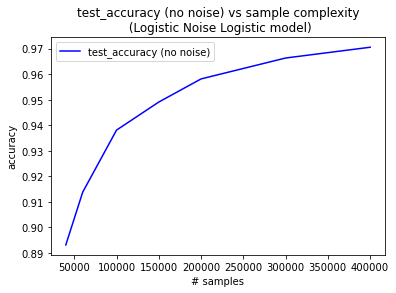

In [31]:
plt.plot(J, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (no noise) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "test_accuracy_(no_noise)_vs_sample_complexity")
plt.show()

In [32]:
np.savetxt(csv_path + "sample_complexity_test_accuracy_no_noise.csv", 
           test_accuracy_no_noise,
           delimiter =", ", 
           fmt ='% s')

In [33]:
np.savetxt(csv_path + "sample_complexity_number_samples_list.csv", 
           J,
           delimiter =", ", 
           fmt ='% s')

In [34]:
test_accuracy_noisy  = [H[i].accuracy(H[i].X_test, H[i].Y_test, H[i].D_test) for i in range(len(H))]

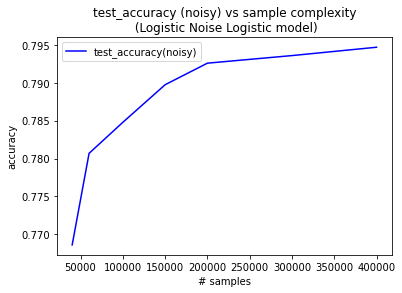

In [35]:
plt.plot(J, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (noisy) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "test_accuracy_(noisy)_vs_sample_complexity")
plt.show()

In [36]:
np.savetxt(csv_path + "sample_complexity_test_accuracy_noisy.csv", 
           test_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [37]:
train_accuracy_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_T) for i in range(len(H))]

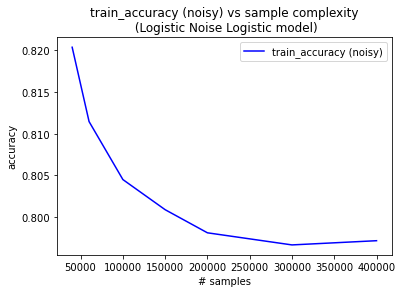

In [38]:
plt.plot(J, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (noisy) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "train_accuracy_(noisy)_vs_sample_complexity")
plt.show()

In [39]:
np.savetxt(csv_path + "sample_complexity_train_accuracy_noisy.csv", 
           train_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [40]:
train_accuracy_no_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_no_noise_T) for i in range(len(H))]

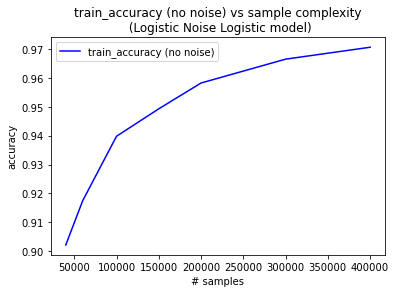

In [41]:
plt.plot(J, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (no noise) vs sample complexity'+ title_suffix, fontsize=12)
plt.savefig(image_path + "train_accuracy_(no_noise)_vs_sample_complexity")
plt.show()

### 

In [42]:
np.savetxt(csv_path + "sample_complexity_train_accuracy_no_noisy.csv", 
           train_accuracy_no_noisy,
           delimiter =", ", 
           fmt ='% s')

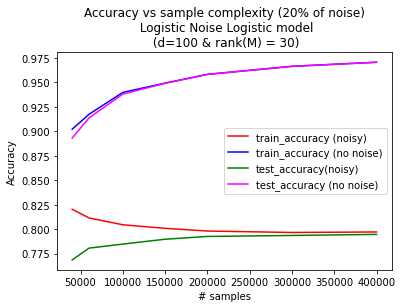

In [61]:
plt.plot(J[:], train_accuracy_noisy[:], label = 'train_accuracy (noisy)', color = 'red')
plt.plot(J[:], train_accuracy_no_noisy[:], label = 'train_accuracy (no noise)', color = 'blue')
plt.plot(J[:], test_accuracy_noisy[:], label = 'test_accuracy(noisy)', color = 'green')
plt.plot(J[:], test_accuracy_no_noise[:], label = 'test_accuracy (no noise)', color = 'magenta')

plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy vs sample complexity (20% of noise)' + title_suffix, fontsize=12)
plt.savefig(image_path + "all_accuracy_vs_sample_complexity_large_d", bbox_inches='tight')
plt.show()

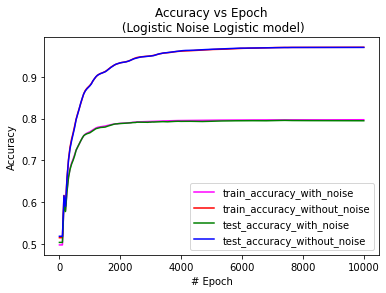

In [44]:
I = H[-1].epoch_history[:]
plt.plot(I, H[-1].train_accuracy_with_noise[:], label = 'train_accuracy_with_noise', color = 'magenta')
plt.plot(I, H[-1].train_accuracy_without_noise[:], label = 'train_accuracy_without_noise', color = 'red')
plt.plot(I, H[-1].test_accuracy_with_noise[:], label = 'test_accuracy_with_noise', color = 'green')
plt.plot(I, H[-1].test_accuracy_without_noise[:], label = 'test_accuracy_without_noise', color = 'blue')
plt.legend()
plt.xlabel('# Epoch', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy vs Epoch' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'all_accuracy_vs_epoch')
plt.show()

In [45]:
L_1_f_norm_history = [m.L_1_f_norm_history[-1] for m in H]

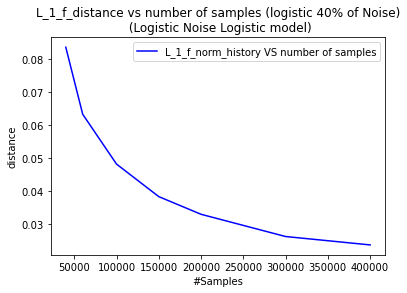

In [46]:
plt.plot(J, L_1_f_norm_history, label = 'L_1_f_norm_history VS number of samples', color = 'blue')
plt.legend()
plt.xlabel('#Samples', fontsize=10)
plt.ylabel('distance', fontsize=10)
plt.title('L_1_f_distance vs number of samples (logistic 40% of Noise)' + title_suffix, fontsize=12)
plt.savefig(image_path + "L_1_f_norm_history_vs_samples")
plt.show()

In [47]:
model = H[-1]

In [48]:
M_hat = (model.B @ model.B.T).detach().numpy()*s
M_star = data_model.M_t
tau_hat = model.Tau.detach().numpy()[0]*s
tau_star = data_model.tau_t[0]

print((np.abs(M_hat - M_star)).max())
print(np.abs(tau_hat-tau_star))

0.023641735726657218
0.13462991713216965


In [49]:
M_hat_normal = model.B @ model.B.T / model.Tau[0]

In [50]:
M_t_normal = data_model.M_t/tau[0]

In [51]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).max()

0.00203584185936943

In [52]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).mean()

0.0002553323821263665

In [53]:
np.sqrt(np.sum((M_t_normal - M_hat_normal.detach().numpy())**2))/np.sqrt((M_t_normal**2).sum())

0.1507176727291603

In [54]:
print(model.Tau.detach().numpy())
print(np.array(tau))
print(np.array(tau)[0]/model.Tau.detach().numpy()[0], s)

[7.24358006]
[11]
1.5185861019144369 1.5


In [55]:
L_1_f_norm(f, model.B.detach().numpy(), model.Tau.detach().numpy(), 
           data_model.B_t, data_model.tau_t, N = 10000)

0.02264205099059176

In [56]:
print(loss(X_T - Y_T, D_T, data_model.B_t/np.sqrt(s), data_model.tau_t/s, Type = model_type).item())
print(loss(X_T - Y_T, D_T, model.B, model.Tau, Type = model_type).item())
print(model.loss_history[-1].item())

0.43431384707423376
0.43133962333242715
0.43133962333242715


In [81]:
H_2 = []
J_2 = []
for N in [5000, 10000, 15000, 20000, 30000]:
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = gen_data(f, 
                                                                                         N + 50000, 
                                                                                         n_train = N, 
                                                                                         tau = np.array(tau), 
                                                                                         noise_type = noise_type,
                                                                                         noise_par = s,
                                                                                         data_model = data_model)
        
    print('round for N = {} has started'.format(N))
    
    J_2.append(N)

    t_1 = time.time()
    model_2 = ML(d, k, n_labels, 
               X_T, Y_T, D_T, D_no_noise_T, 
               X_test, Y_test, D_test, 
               D_no_noise_test, Type = model_type) 
    
    model_2.train(learning_rate = 1e-1, 
                n_iters = 10000, 
                decay = .95, 
                show_log = False,
                f = f, 
                B_star = data_model.B_t, 
                tau_star = data_model.tau_t, 
                N = 1000)
    H_2.append(model_2)
    print('For N = {}\n training time is {},'.format(N, time.time()-t_1))
    print('train_accuracy_with_noise is {},'.format(model_2.train_accuracy_with_noise[-1]))
    print('train_accuracy_without_noise is {},'.format(model_2.train_accuracy_without_noise[-1]))
    print('test_accuracy_with_noise is {},'.format(model_2.test_accuracy_with_noise[-1]))
    print('test_accuracy_without_noise is {}.\n'.format(model_2.test_accuracy_without_noise[-1]))

round for N = 5000 has started
For N = 5000
 training time is 136.9570209980011,
train_accuracy_with_noise is 0.9946,
train_accuracy_without_noise is 0.8036,
test_accuracy_with_noise is 0.6803,
test_accuracy_without_noise is 0.73932.

round for N = 10000 has started
For N = 10000
 training time is 250.75917530059814,
train_accuracy_with_noise is 0.9053,
train_accuracy_without_noise is 0.8303,
test_accuracy_with_noise is 0.71904,
test_accuracy_without_noise is 0.7979.

round for N = 15000 has started
For N = 15000
 training time is 363.1544461250305,
train_accuracy_with_noise is 0.868,
train_accuracy_without_noise is 0.8557333333333333,
test_accuracy_with_noise is 0.73932,
test_accuracy_without_noise is 0.8307.

round for N = 20000 has started
For N = 20000
 training time is 476.03239274024963,
train_accuracy_with_noise is 0.84885,
train_accuracy_without_noise is 0.8722,
test_accuracy_with_noise is 0.75146,
test_accuracy_without_noise is 0.85284.

round for N = 30000 has started
For N =

In [86]:
J_new = [5000, 10000, 15000, 20000, 30000, 40000, 60000, 100000, 150000, 200000, 300000, 400000]
model_list = H_2 + H

In [91]:
len(J_new)

12

In [92]:
list_train_accuracy_with_noise = [model_list[i].train_accuracy_with_noise[-1] for i in range(12)]
list_train_accuracy_without_noise = [model_list[i].train_accuracy_without_noise[-1] for i in range(12)]
list_test_accuracy_with_noise = [model_list[i].test_accuracy_with_noise[-1] for i in range(12)]
list_test_accuracy_without_noise = [model_list[i].test_accuracy_without_noise[-1] for i in range(12)]

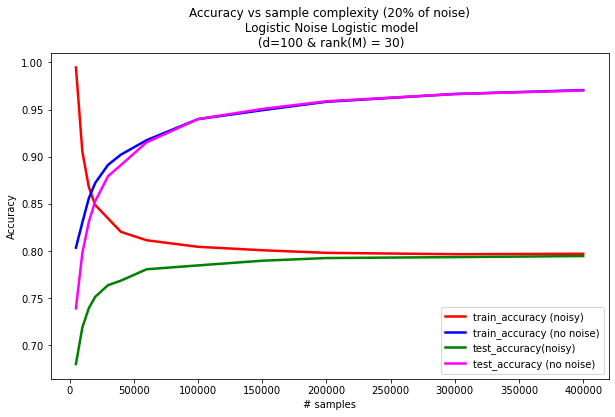

In [93]:
plt.figure(figsize=(10,6))
plt.plot(J_new[:], list_train_accuracy_with_noise[:], label = 'train_accuracy (noisy)', 
         color = 'red', linewidth = 2.5)
plt.plot(J_new[:], list_train_accuracy_without_noise[:], label = 'train_accuracy (no noise)', 
         color = 'blue', linewidth = 2.5)
plt.plot(J_new[:], list_test_accuracy_with_noise[:], label = 'test_accuracy(noisy)', 
         color = 'green',linewidth = 2.5)
plt.plot(J_new[:], list_test_accuracy_without_noise[:], label = 'test_accuracy (no noise)', 
         color = 'magenta', linewidth = 2.5)

plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy vs sample complexity (20% of noise)' + title_suffix, fontsize=12)
plt.savefig(image_path + "all_accuracy_vs_sample_complexity_large_d_new", bbox_inches='tight')
plt.show()

In [95]:
list_test_accuracy_without_noise[-1]

0.97022

In [96]:
list_test_accuracy_without_noise

[0.73932,
 0.7979,
 0.8307,
 0.85284,
 0.87934,
 0.89116,
 0.91522,
 0.9399,
 0.95062,
 0.95878,
 0.96644,
 0.97022]

In [79]:
len(H)

14

In [104]:
H_3 = []
J_3 = []
for N in [600000]:
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = gen_data(f, 
                                                                                         N + 50000, 
                                                                                         n_train = N, 
                                                                                         tau = np.array(tau), 
                                                                                         noise_type = noise_type,
                                                                                         noise_par = s,
                                                                                         data_model = data_model)
        
    print('round for N = {} has started'.format(N))
    
    J_3.append(N)

    t_1 = time.time()
    model_3 = ML(d, k, n_labels, 
               X_T, Y_T, D_T, D_no_noise_T, 
               X_test, Y_test, D_test, 
               D_no_noise_test, Type = model_type) 
    
    model_3.train(learning_rate = 1e-1, 
                n_iters = 10000, 
                decay = .95, 
                show_log = False,
                f = f, 
                B_star = data_model.B_t, 
                tau_star = data_model.tau_t, 
                N = 1000)
    H_3.append(model_3)
    print('For N = {}\n training time is {},'.format(N, time.time()-t_1))
    print('train_accuracy_with_noise is {},'.format(model_3.train_accuracy_with_noise[-1]))
    print('train_accuracy_without_noise is {},'.format(model_3.train_accuracy_without_noise[-1]))
    print('test_accuracy_with_noise is {},'.format(model_3.test_accuracy_with_noise[-1]))
    print('test_accuracy_without_noise is {}.\n'.format(model_3.test_accuracy_without_noise[-1]))

round for N = 600000 has started
For N = 600000
 training time is 19345.86124396324,
train_accuracy_with_noise is 0.7962533333333334,
train_accuracy_without_noise is 0.9759066666666667,
test_accuracy_with_noise is 0.7923,
test_accuracy_without_noise is 0.97558.



In [106]:
J_F = [5000, 10000, 15000, 20000, 30000, 40000, 60000, 100000, 150000, 200000, 300000, 400000, 600000]
model_list = H_2 + H + H_3

In [107]:
list_train_accuracy_with_noise = [model_list[i].train_accuracy_with_noise[-1] for i in range(13)]
list_train_accuracy_without_noise = [model_list[i].train_accuracy_without_noise[-1] for i in range(13)]
list_test_accuracy_with_noise = [model_list[i].test_accuracy_with_noise[-1] for i in range(13)]
list_test_accuracy_without_noise = [model_list[i].test_accuracy_without_noise[-1] for i in range(13)]

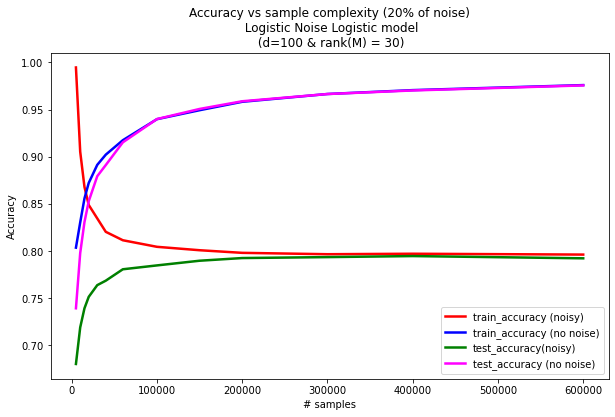

In [109]:
plt.figure(figsize=(10,6))
plt.plot(J_F[:], list_train_accuracy_with_noise[:], label = 'train_accuracy (noisy)', 
         color = 'red', linewidth = 2.5)
plt.plot(J_F[:], list_train_accuracy_without_noise[:], label = 'train_accuracy (no noise)', 
         color = 'blue', linewidth = 2.5)
plt.plot(J_F[:], list_test_accuracy_with_noise[:], label = 'test_accuracy(noisy)', 
         color = 'green',linewidth = 2.5)
plt.plot(J_F[:], list_test_accuracy_without_noise[:], label = 'test_accuracy (no noise)', 
         color = 'magenta', linewidth = 2.5)

plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy vs sample complexity (20% of noise)' + title_suffix, fontsize=12)
plt.savefig(image_path + "all_accuracy_vs_sample_complexity_large_d_new", bbox_inches='tight')
plt.show()